# Проект: классификация

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from  sklearn.ensemble import IsolationForest
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing  import LabelEncoder
from sklearn import linear_model 
from sklearn import tree 
from sklearn import ensemble 
from sklearn import metrics 
from sklearn import preprocessing
from sklearn import model_selection 
from sklearn.model_selection import train_test_split 
from sklearn.feature_selection import SelectKBest, f_classif

## Часть 1. Знакомство с данными, обработка пропусков и выбросов

In [2]:
df = pd.read_csv('bank_fin.csv', sep = ';') # прочитаем файл
df.head() # выведем первые 5 строк

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,"2 343,00 $",yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,"45,00 $",no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,"1 270,00 $",yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,"2 476,00 $",yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,"184,00 $",no,no,unknown,5,may,673,2,-1,0,unknown,yes


Посмотрим на данные повнимательнее 

In [3]:
df.info() # информация о данных

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        11162 non-null  int64 
 1   job        11162 non-null  object
 2   marital    11162 non-null  object
 3   education  11162 non-null  object
 4   default    11162 non-null  object
 5   balance    11137 non-null  object
 6   housing    11162 non-null  object
 7   loan       11162 non-null  object
 8   contact    11162 non-null  object
 9   day        11162 non-null  int64 
 10  month      11162 non-null  object
 11  duration   11162 non-null  int64 
 12  campaign   11162 non-null  int64 
 13  pdays      11162 non-null  int64 
 14  previous   11162 non-null  int64 
 15  poutcome   11162 non-null  object
 16  deposit    11162 non-null  object
dtypes: int64(6), object(11)
memory usage: 1.4+ MB


Исследуем данные на предмет пропусков: где есть пропущенные значения, сколько их

In [4]:
print(df.isnull().sum())

age           0
job           0
marital       0
education     0
default       0
balance      25
housing       0
loan          0
contact       0
day           0
month         0
duration      0
campaign      0
pdays         0
previous      0
poutcome      0
deposit       0
dtype: int64


Пропущенные (неизвестные) значения могут присутствовать неявным образом. Часто это не является проблемой, но это необходимо выявить. В наших данных именно такая ситуация (в признаке со сферой занятости). Выявим, каким именно словом закодированы пропущенные (неизвестные) значения.

In [5]:
df['job'].sort_values()

0        admin.
2154     admin.
8198     admin.
2155     admin.
8202     admin.
         ...   
5805    unknown
5834    unknown
6338    unknown
4515    unknown
6985    unknown
Name: job, Length: 11162, dtype: object

В значениях признака "balance" так же присутствуют скрытые пропуски - значение NaN. Заменим их на медианные.
Кроме того, в значениях содержится запятая и знак доллара, поэтому не считывается как число. Преобразуем в тип float.

In [6]:
def balance_to_float(row): # функция, убирающая лишние знаки и пробелы
    row = str(row)
    if row != 'unknown':
        row = row.replace(',00', '')
        row = row.replace('$', '')
        row = row.replace(' ', '')
        return float(row) # и возвращающая число
    else:
        return np.nan
    
df['balance'] = df['balance'].apply(balance_to_float) # применим функцию

In [7]:
# заменим нулевые значения на медианные
df['balance'] = df['balance'].fillna(value=df['balance'].median())

In [8]:
df['balance'].value_counts() # проверим значения столбца

 0.0       774
 1.0        39
 2.0        34
 3.0        34
 550.0      31
          ... 
 1641.0      1
 5517.0      1
 8332.0      1
 4859.0      1
-134.0       1
Name: balance, Length: 3802, dtype: int64

Заменим неизвестные значения в признаках job и education на модальные

In [9]:
job_mode = df['job'].mode()[0]
education_mode = df['education'].mode()[0]

df['job'] = df['job'].apply(lambda x: job_mode if x == 'unknown' else x)
df['education'] = df['education'].apply(lambda x: education_mode if x == 'unknown' else x)

Поработаем с выбросами в признаке balance.

Cуществуют более продвинутые методы поиска аномальных значений, но для обработки одного числового признака достаточно хорошо подходит метод Тьюки (размах возьмем 1.5).

In [10]:
q1 = df.balance.quantile(0.25) # 25й персентиль
q3 = df.balance.quantile(0.75) # 75й персентиль
iqr = q3 - q1 # межкватильный размах
low = q1 - (iqr * 1.5) # нижняя граница
up = q3 + (iqr * 1.5) # верхняя граница
# отбросим значения, которые лежат за границами
df = df[(df['balance'] >= low) & (df['balance'] <= up)] 

## Часть 2:  Разведывательный анализ

### Изучим соотношение классов в целевой переменной

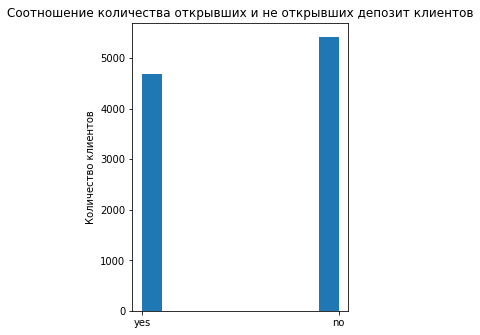

In [11]:
fig = plt.figure(figsize=(3, 4))
axes = fig.add_axes([0, 0, 1, 1])
axes.hist(x=df['deposit'])
axes.set_title('Соотношение количества открывших и не открывших депозит клиентов')
axes.set_ylabel('Количество клиентов')
plt.show()

Соотношение клиетов, открывших депозит и не открывших достаточно сбалансировано.
Посмотрим точное количество пользователей, открывших депозит.

In [12]:
df['deposit'].value_counts()

no     5424
yes    4681
Name: deposit, dtype: int64

Депозит открыли 4681 человек.

### Посмотрим на описательные статистики.

#### Начнем с количественных переменных.

In [13]:
df.describe()

,age,balance,day,duration,campaign,pdays,previous
count,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000
mean,40.895497,807.653538,15.590302,368.742603,2.517170,51.319644,0.816230
std,11.734931,994.151966,8.441510,346.651524,2.707159,109.644179,2.243795
min,18.000000,-2049.000000,1.000000,2.000000,1.000000,-1.000000,0.000000
25%,32.000000,95.000000,8.000000,137.000000,1.000000,-1.000000,0.000000
50%,38.000000,445.000000,15.000000,252.000000,2.000000,-1.000000,0.000000
75%,48.000000,1227.000000,22.000000,490.000000,3.000000,2.000000,1.000000
max,95.000000,4063.000000,31.000000,3881.000000,43.000000,854.000000,58.000000


Визуализируем распределение количественных переменных

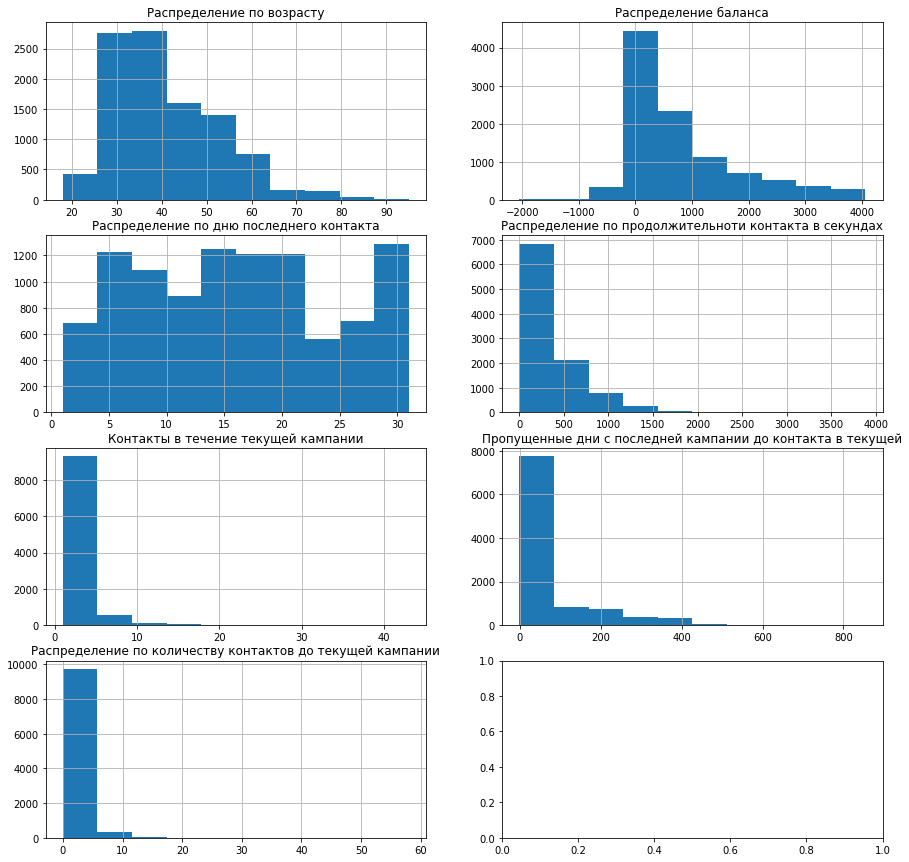

In [14]:
fig, axes = plt.subplots(nrows=4, ncols=2,figsize=(15,15)) # создадим плоскости

axes[0,0].hist(x=df['age']) # гистограмма для age
axes[0,0].set_title('Распределение по возрасту')
axes[0,0].grid()

axes[0,1].hist(x=df['balance']) # гистограмма для balance
axes[0,1].set_title('Распределение баланса')
axes[0,1].grid()

axes[1,0].hist(x=df['day']) # гистограмма для day
axes[1,0].set_title('Распределение по дню последнего контакта')
axes[1,0].grid()

axes[1,1].hist(x=df['duration']) # гистограмма для duration
axes[1,1].set_title('Распределение по продолжительноти контакта в секундах')
axes[1,1].grid()

axes[2,0].hist(x=df['campaign']) # гистограмма для campaign
axes[2,0].set_title('Контакты в течение текущей кампании')
axes[2,0].grid()

axes[2,1].hist(x=df['pdays']) # гистограмма для pdays
axes[2,1].set_title('Пропущенные дни с последней кампании до контакта в текущей')
axes[2,1].grid()

axes[3,0].hist(x=df['previous']) # гистограмма для previous
axes[3,0].set_title('Распределение по количеству контактов до текущей кампании')
axes[3,0].grid()

### Первые выводы по количественным переменным:

Возраст клиентов банка от 18 до 95, средний возраст - 41 год. Основная возрастная группа, как видно на графике, 25-40 лет.

Баланс на счетах от -2000 до 4000 (примерно), однако значения меньше -1000 единичны, их можно будет отнести к выбросам. Основные значения - чуть меньше 0 и до 1000.

Насчет дня последнего контакта сложно что-то сказать, вряд ли этот признак играет большую роль.

Количество контактов в течение предыдущей маркетинговой компании - не больше 5, интервал связи с клиентами по новой компании - около 70 дней, в рамках новой компании проходит не больше 5 контактов, продолжительность разговора в среднем около 6 минут.

#### Категориальные переменные.

In [15]:
df.describe(include=['object'])

,job,marital,education,default,housing,loan,contact,month,poutcome,deposit
count,10105,10105,10105,10105,10105,10105,10105,10105,10105,10105
unique,11,3,3,2,2,2,3,12,4,2
top,management,married,secondary,no,no,no,cellular,may,unknown,no
freq,2315,5715,5517,9939,5243,8712,7283,2617,7570,5424


Text(0.5, 1.0, 'Результат прошлой маркетинговой кампании')

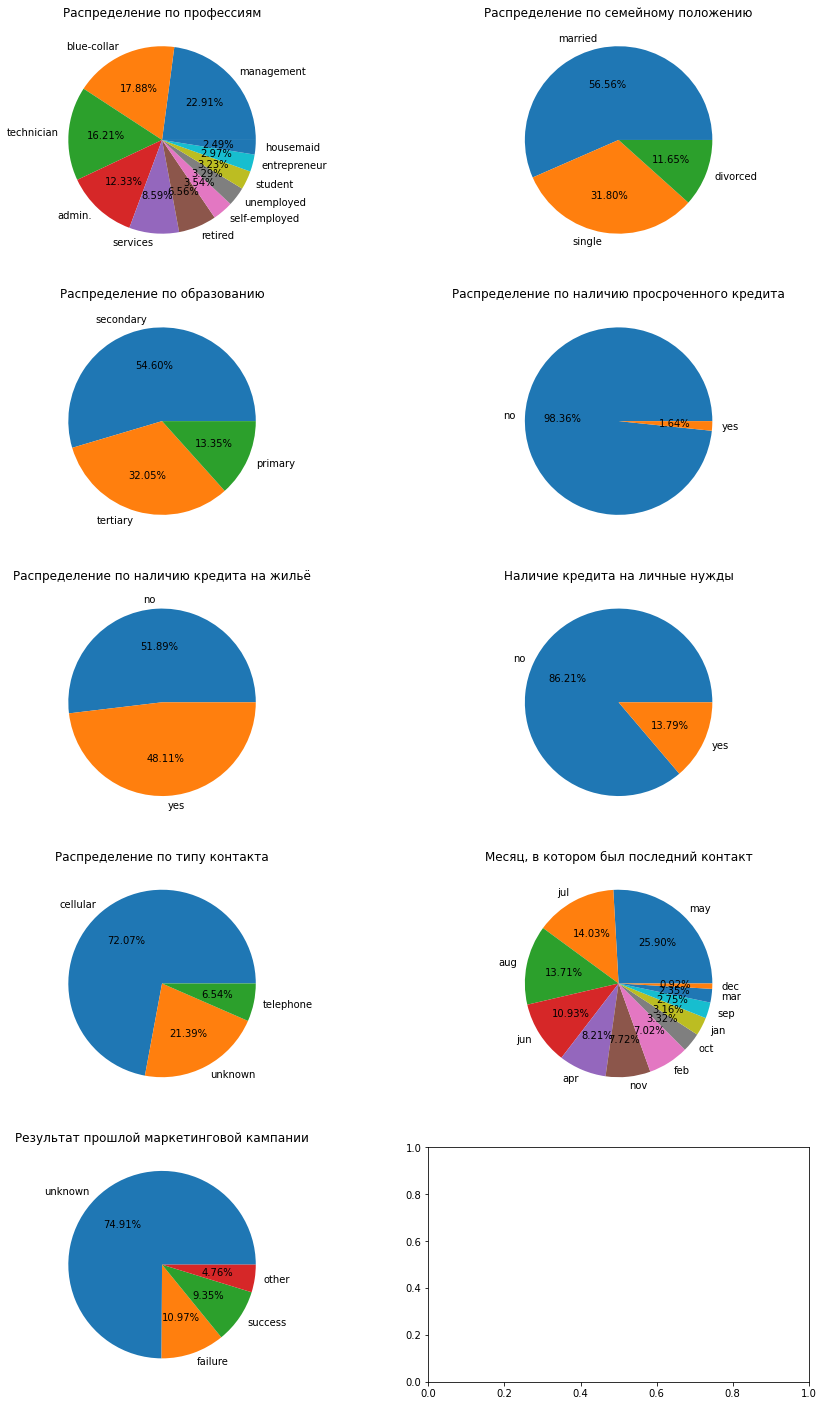

In [16]:
fig, axes = plt.subplots(nrows=5, ncols=2,figsize=(15,25))

# круговая диаграмма для job
job_top = df['job'].value_counts()
axes[0,0].pie(
    job_top,
    labels=job_top.index, # названия секторов - индексы
    autopct='%.2f%%', # подписи - округление до 2 знаков + '%'
)
axes[0,0].set_title('Распределение по профессиям') # название графика 

# круговая диаграмма для marital
marital = df['marital'].value_counts()
axes[0,1].pie(
    marital,
    labels=marital.index,
    autopct='%.2f%%',
)
axes[0,1].set_title('Распределение по семейному положению')

# круговая диаграмма для education
education = df['education'].value_counts()
axes[1,0].pie(
    education,
    labels=education.index,
    autopct='%.2f%%',
)
axes[1,0].set_title('Распределение по образованию')

# круговая диаграмма для default
default = df['default'].value_counts()
axes[1,1].pie(
    default,
    labels=default.index,
    autopct='%.2f%%',
)
axes[1,1].set_title('Распределение по наличию просроченного кредита')

# круговая диаграмма для housing
housing = df['housing'].value_counts()
axes[2,0].pie(
    housing,
    labels=housing.index,
    autopct='%.2f%%',
)
axes[2,0].set_title('Распределение по наличию кредита на жильё')

# круговая диаграмма для loan
loan = df['loan'].value_counts()
axes[2,1].pie(
    loan,
    labels=loan.index,
    autopct='%.2f%%',
)
axes[2,1].set_title('Наличие кредита на личные нужды')

# круговая диаграмма для contact
contact = df['contact'].value_counts()
axes[3,0].pie(
    contact,
    labels=contact.index,
    autopct='%.2f%%',
)
axes[3,0].set_title('Распределение по типу контакта')

# круговая диаграмма для month
month = df['month'].value_counts()
axes[3,1].pie(
    month,
    labels=month.index,
    autopct='%.2f%%',
)
axes[3,1].set_title('Месяц, в котором был последний контакт')

# круговая диаграмма для poutcome
poutcome = df['poutcome'].value_counts()
axes[4,0].pie(
    poutcome,
    labels=poutcome.index,
    autopct='%.2f%%',
)
axes[4,0].set_title('Результат прошлой маркетинговой кампании')

##### Первые выводы по категориальным переменным:

Самая распространённая профессия среди клиентов банка - менеджер, немного отстают рабочие и технические специалисты.

Чуть больше половины клиентов состоят в браке, треть одиноки, и лишь небольшая часть в разводе.

Половина клиентов имеент среднее образование, чуть меньше - профессиональное, и небольшая часть - начальное.

Подавляющее количество клиентов не имеет просроченного кредита. Половина клиентов имеют кредит на жильё, и большинство - кредит на личные нужды.

Четверть всех контактов с клиентами состоялась в мае, почти всегда по мобильному телефону.

Большинство данных о результатах предыдущей маркетинговой компании неизвестно, однако количество положительных и отрицательных результатов из тех, что известны, примерно равно.

##### Посмотрим за зависимость целевой переменной от некоторых факторов

Узнаем, есть ли разница в результатах текущей маркетинговой кампании и предыдущей. Возможно, люди, которые уже однажды согласились на предложение банка, более склонны принять его вновь. А возможно, ситуация ровно обратная. Посмотрим, для какого статуса предыдущей маркетинговой кампании успех в текущей превалирует над количеством неудач.

In [17]:
df[df['deposit'] == 'yes']['poutcome'].value_counts()

unknown    3008
success     861
failure     547
other       265
Name: poutcome, dtype: int64

Видим, что, если не брать в расчет неуточненные данные, то клиенты, принявшие предложение банка в прошлой кампании, в большинстве своем приняли положительное предложение и в этой кампании.

##### Выясним, в каком месяце самый большой процент неудач при взаимодействии в текущей маркетинговой кампании.

In [18]:
df[df['deposit'] == 'no']['month'].value_counts()

may    1776
jul     836
aug     775
jun     606
nov     456
feb     323
apr     317
jan     194
oct      62
sep      46
mar      24
dec       9
Name: month, dtype: int64

Как мы уже выяснили, большинство предложений было сделано именно в мае. Возможно, предполагалось, что в преддверии летних отпусков клиенты охотнее примут предложение банка, однако это оказалось не так.

##### Определим, в каких группах более склонны открывать депозит, чем отказываться от предложения

deposit
no     AxesSubplot(0.125,0.125;0.775x0.755)
yes    AxesSubplot(0.125,0.125;0.775x0.755)
Name: age_groups, dtype: object

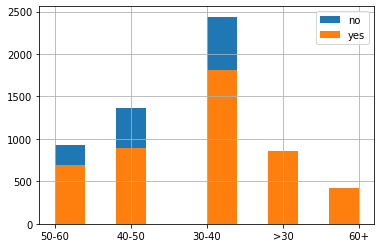

In [19]:
def get_age_group(age): # разобьем клиентов по возрастным группам
    if age < 30:
        return '>30'
    elif 30 <= age <= 40:
        return '30-40' 
    elif 40 < age <= 50:
        return '40-50'
    elif 50 < age <= 60:
        return '50-60'
    elif age > 60:
        return '60+'

data = pd.DataFrame()     
data['age_groups'] = df['age'].apply(get_age_group) # создадим новую переменную - принадлежность к группе
data['deposit'] = df['deposit']

data.groupby(['deposit'])['age_groups'].hist(legend=True)


Среди клиентов возрастных групп до 30 и больше 60 лет положительных решений явно больше, чем отрицательных

##### Построим визуализации для открывших и неоткрывших депозит в зависимости от семейного статуса

deposit
no     AxesSubplot(0.125,0.125;0.775x0.755)
yes    AxesSubplot(0.125,0.125;0.775x0.755)
Name: marital, dtype: object

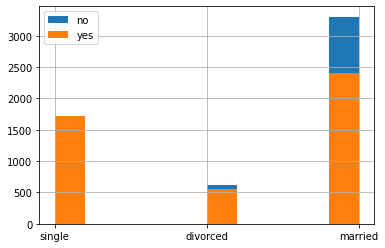

In [20]:
df.groupby(['deposit'])['marital'].hist(legend=True)

Среди одиноких клиентов самая большая доля открывших депозит, среди разведенных есть небольшой процент отказавшихся, а среди состоящих в браке отказавшихся больше, чем в других группах. 

##### Построим визуализации для открывших и неоткрывших депозит в зависимости от образования

deposit
no     AxesSubplot(0.125,0.125;0.775x0.755)
yes    AxesSubplot(0.125,0.125;0.775x0.755)
Name: education, dtype: object

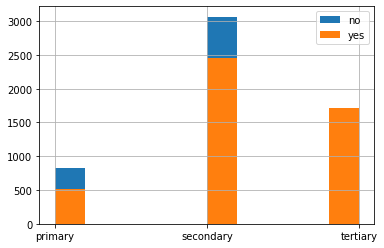

In [21]:
df.groupby(['deposit'])['education'].hist(legend=True)

Люди с профессиональным образованием склонны чаще открывать депозит.

##### Построим визуализацию для открывших и неоткрывших депозит в зависимости от вида профессиональной занятости

deposit
no     AxesSubplot(0.125,0.125;0.775x0.755)
yes    AxesSubplot(0.125,0.125;0.775x0.755)
Name: job, dtype: object

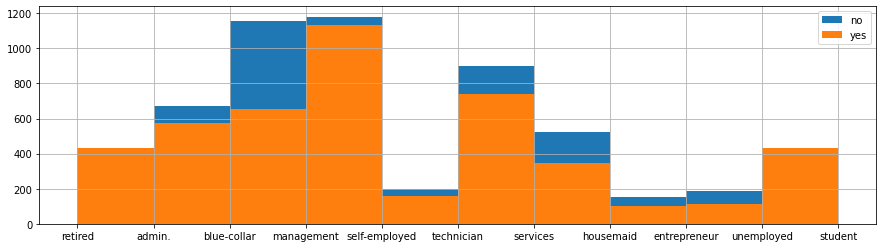

In [22]:
df.groupby(['deposit'])['job'].hist(figsize=(15, 4), legend=True)

Самая маленькая доля отказов - у пенсионеров и студентов. Чуть больше - у самозанятых, менеджеров и домохозяек.

##### Посмотрим, каких людей среди открывших депозит больше: одиноких с высшим образованием или разведённых с более низким уровнем образования.

Text(0.5, 1.0, 'Тепловая карта зависимости депозита от уровня образования и семейного положения для открывших депозит')

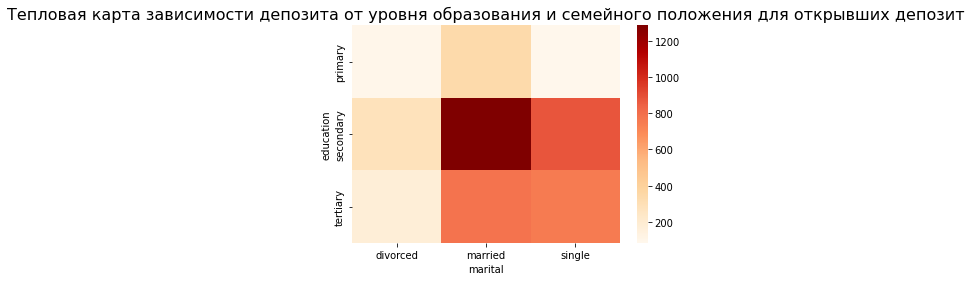

In [23]:

# разделим данные на 2 датафрейма - открывших и не открывших депозит 
df_yes = df[df['deposit'] == 'yes']
df_no = df[df['deposit'] == 'no']

# для каждого нового датафрейма создадим таблицы, показывающие, как часто встречаются в них интересующие нас признаки в разных сочетаниях
df_yes_tab = pd.crosstab( # для открывших депозит
    index=df_yes['education'],
    columns=df_yes['marital']
)
df_no_tab = pd.crosstab( # для  не открывших депозит
    index=df_no['education'],
    columns=df_no['marital']
)

# для каждой таблицы построим тепловую карту
heatmap = sns.heatmap(df_yes_tab, cmap='OrRd')
heatmap.set_title('Тепловая карта зависимости депозита от уровня образования и семейного положения для открывших депозит', fontsize=16)


Text(0.5, 1.0, 'Тепловая карта зависимости депозита от уровня образования и семейного положения для  не открывших депозит')

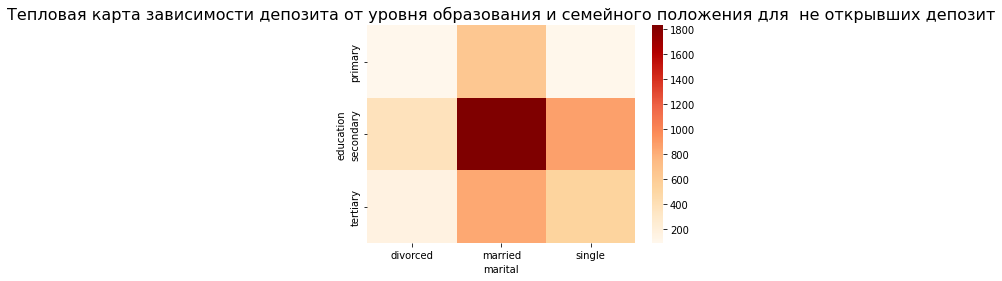

In [24]:
heatmap = sns.heatmap(df_no_tab, cmap='OrRd')
heatmap.set_title('Тепловая карта зависимости депозита от уровня образования и семейного положения для  не открывших депозит', fontsize=16)

##### Вывод:
Видим, что и среди открывших депозит, и среди неоткрывших преобладают люди в браке со средним образованием.
При этом среди открывших депозит одиноких с высшим образованием больше, чем разведенных с начальным образованием.

## Часть 3: преобразование данных

### Начнём с обработки категориального порядкового признака, который отвечает за уровень образования

In [25]:
# преобразуем education с помощью метода LabelEncoder без дополнительных настроек
l_encoder = LabelEncoder()
df['education'] = l_encoder.fit_transform(df['education'])

### Так же закодируем age, используя переменную, разбивающую возраст на группы 

In [27]:
df['age_groups'] = l_encoder.fit_transform(data['age_groups'])

### Перекодируем переменную deposit таким образом, чтобы вместо yes она принимала значение 1, а вместо no — 0

In [28]:
df['deposit'] = df['deposit'].apply(lambda x: 1 if x=='yes' else 0)

### Так же преобразуем бинарные переменные (default, housing, loan)

In [30]:
df['default'] = df['default'].apply(lambda x: 1 if x=='yes' else 0)
df['housing'] = df['housing'].apply(lambda x: 1 if x=='yes' else 0)
df['loan'] = df['loan'].apply(lambda x: 1 if x=='yes' else 0)
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit,age_groups
0,59,admin.,married,1,0,2343.0,1,0,unknown,5,may,1042,1,-1,0,unknown,1,2
1,56,admin.,married,1,0,45.0,0,0,unknown,5,may,1467,1,-1,0,unknown,1,2
2,41,technician,married,1,0,1270.0,1,0,unknown,5,may,1389,1,-1,0,unknown,1,1
3,55,services,married,1,0,2476.0,1,0,unknown,5,may,579,1,-1,0,unknown,1,2
4,54,admin.,married,2,0,184.0,0,0,unknown,5,may,673,2,-1,0,unknown,1,2


###  Преобразуем номинальные переменные, которые могут принимать несколько различных значений (job, marital, contact, month, poutcome). Создадим для них dummy-переменные и добавим их в набор данных.

In [32]:
df = pd.get_dummies(df, drop_first=False)

### Теперь оценим мультиколлинеарность и взаимосвязь признаков с целевой переменной.

In [34]:
# построим корреляционную матрицу
df.corr()

,age,education,default,balance,housing,loan,day,duration,campaign,pdays,...,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown
age,1.000000,-0.191124,-0.009929,0.115164,-0.164196,-0.026357,0.000396,-0.006007,-0.001143,0.006107,...,0.009769,0.024785,-0.119656,0.026875,0.056998,0.036352,0.001994,-0.020942,0.060009,-0.031455
education,-0.191124,1.000000,-0.015692,0.043251,-0.094350,-0.052566,0.008989,-0.016869,-0.012280,0.024123,...,-0.036503,0.052196,-0.104157,0.028704,0.027617,0.030846,0.019845,0.015103,0.070489,-0.069069
default,-0.009929,-0.015692,1.000000,-0.110928,0.009551,0.074786,0.018724,-0.008162,0.033404,-0.037323,...,0.019626,-0.020028,-0.001761,0.000544,-0.023931,-0.016977,-0.025450,-0.017923,-0.041510,0.055032
balance,0.115164,0.043251,-0.110928,1.000000,-0.094919,-0.113089,-0.009987,0.025781,-0.042689,0.045155,...,0.039753,0.043832,-0.098073,0.081861,0.057041,0.047841,0.031040,0.028111,0.073358,-0.085456
housing,-0.164196,-0.094350,0.009551,-0.094919,1.000000,0.072252,-0.022644,0.038492,0.006257,0.064138,...,-0.073133,-0.075948,0.432605,-0.000219,-0.092026,-0.086893,0.085167,0.009830,-0.134477,0.024082
loan,-0.026357,-0.052566,0.074786,-0.113089,0.072252,1.000000,0.019136,0.001476,0.033889,-0.030788,...,-0.014897,-0.041105,0.002778,0.017720,-0.032357,-0.046196,0.007458,-0.019289,-0.082098,0.059235
day,0.000396,0.008989,0.018724,-0.009987,-0.022644,0.019136,1.000000,-0.016695,0.142169,-0.078757,...,-0.182032,-0.044303,-0.014580,0.056471,0.072179,-0.068744,-0.071175,-0.008806,-0.044366,0.085442
duration,-0.006007,-0.016869,-0.008162,0.025781,0.038492,0.001476,-0.016695,1.000000,-0.042576,-0.033053,...,-0.003061,-0.034640,0.007983,-0.015655,-0.012541,-0.012077,-0.039476,-0.009497,-0.025971,0.050571
campaign,-0.001143,-0.012280,0.033404,-0.042689,0.006257,0.033889,0.142169,-0.042576,1.000000,-0.105214,...,0.046763,-0.030574,-0.044348,-0.077307,-0.071519,-0.048672,-0.082282,-0.024854,-0.094260,0.134842
pdays,0.006107,0.024123,-0.037323,0.045155,0.064138,-0.030788,-0.078757,-0.033053,-0.105214,1.000000,...,-0.093551,0.024192,0.028678,-0.007350,0.079833,0.110907,0.608719,0.338049,0.326215,-0.824031


<AxesSubplot:>

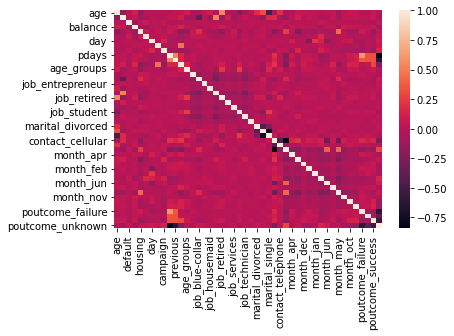

In [35]:
# для наглядности изобразим это на тепловой карте
sns.heatmap(df.corr())

<AxesSubplot:>

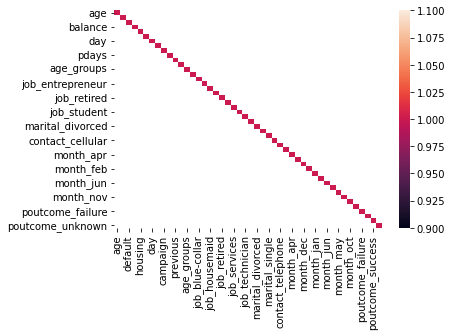

In [36]:
# отфильтруем только значения больше 0.9
corr = df.corr()
corr = corr[corr.abs() >= 0.9]
sns.heatmap(corr)

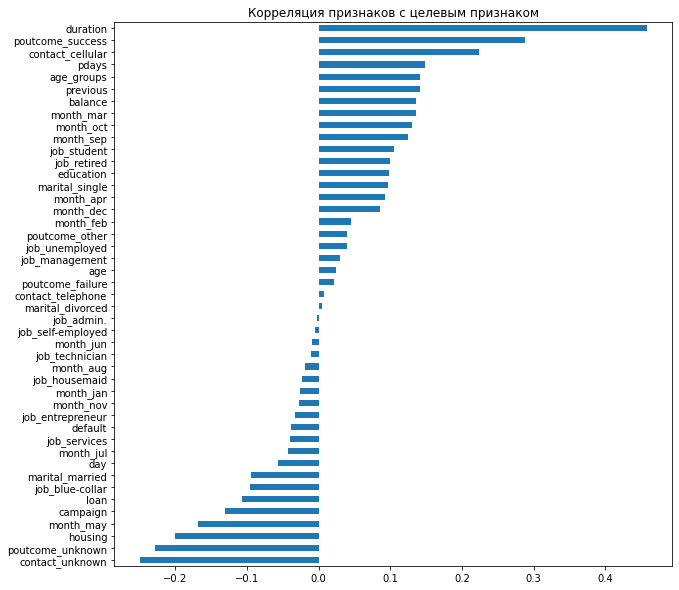

In [37]:
# построим столбчатую диаграмму для ранжированных коэффициентов корреляции c deposit
corr = df.corr()
corr['deposit'].apply(lambda x: x).sort_values()[:-1].plot.barh(figsize=(10,10))
plt.title('Корреляция признаков с целевым признаком')
plt.show()

##### В данных нет признаков с сильной мультиколлинеарностью (больше 0.9), мультиколлинеарности с целевым признаком не наблюдается.

### Определим целевую переменную и предикторы, а также разделим выборку на обучающую и тестовую

In [38]:
X = df.drop(['deposit'], axis=1) # матрица наблюдений
y = df['deposit'] # целевая переменная

# разбивка на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 42, test_size = 0.33)

### С помощью SelectKBest отберём 15 признаков, которые сильнее всего связаны с целевой переменной.

In [41]:
# инциируем класс SelectKBest
selector = SelectKBest(score_func = f_classif, k=15)
# применим его к обучающей выборке
selector.fit(X_train, y_train)

# выведем названия выделенных признаков 
selector.get_feature_names_out()

array(['balance', 'housing', 'duration', 'campaign', 'pdays', 'previous',
       'age_groups', 'contact_cellular', 'contact_unknown', 'month_mar',
       'month_may', 'month_oct', 'month_sep', 'poutcome_success',
       'poutcome_unknown'], dtype=object)

In [42]:
# оставим в данных только выбранные признаки
df = df[['balance', 'housing', 'duration', 'campaign', 'pdays', 'previous',
       'age_groups', 'contact_cellular', 'contact_unknown', 'month_mar',
       'month_may', 'month_oct', 'month_sep', 'poutcome_success',
       'poutcome_unknown']]

X = df # новая матрица 
# Новую выборку разобьем на тренировочную и тестовую
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42, test_size=0.33)

### Данные необходимо нормализовать. Есть разные варианты нормализации, но мы будем использовать min-max-нормализацию.

In [43]:
# Нормализуем предикторы в обучающей и тестовой выборках.
mm_scaler = preprocessing.MinMaxScaler()
mm_scaler.fit(X_train)
X_train_scaled = mm_scaler.transform(X_train)
X_test_scaled = mm_scaler.transform(X_test)

# Часть 4: Решение задачи классификации: логистическая регрессия и решающие деревья

### Для начала реализуем логистическую регрессию.

In [45]:
from sklearn.linear_model import LogisticRegression

log_reg = linear_model.LogisticRegression( # модель
    solver='sag',
    random_state=42,
    max_iter=1000
)
log_reg.fit(X_train_scaled, y_train) # обучение модели

# предсказание для тестовой выборки
y_test_predict = log_reg.predict(X_test_scaled)

# accuracy на тестовой выборке
print(metrics.accuracy_score(y_test, y_test_predict).round(2))

0.81


### Oбучим ещё один алгоритм — решающие деревья. Глубину оставим по умолчанию.

In [46]:
dt = tree.DecisionTreeClassifier(
    criterion='entropy',
    random_state=42,
)

dt.fit(X_train_scaled, y_train) # обучение модели

# предсказание для обучающей выборки
y_train_predict = dt.predict(X_train_scaled)
# предсказание для тестовой выборки
y_test_predict = dt.predict(X_test_scaled)

# метрики
print('Train:', metrics.accuracy_score(y_train, y_train_predict))
print('Test:', metrics.accuracy_score(y_test, y_test_predict).round(2))

Train: 1.0
Test: 0.75


На обучающем наборе данных метрика показывает 100% угадывание, а вот на тестовом метрика упала, что говорит о переобучении модели.

### Подберем гиперпараметры для модели с помощью GridSearch

In [47]:
from sklearn.model_selection import GridSearchCV

# зададим сетку параметров 
parameters = {'min_samples_split': [2, 5, 7, 10], 'max_depth':[3,5,7]}

# укажем модель
model_cv = GridSearchCV(tree.DecisionTreeClassifier(),
                        parameters,
                        cv=3,
                        scoring=('f1'),
                        return_train_score=True)

# обучение модели с сеткой параметров
model_cv.fit(X_train_scaled, y_train)

print('Лучшие гиперпараметры:', model_cv.best_params_)

Лучшие гиперпараметры: {'max_depth': 7, 'min_samples_split': 2}


In [48]:
# создадим решающее дерево с лучшими параметрами
dt_best = tree.DecisionTreeClassifier(
    criterion='entropy',
    random_state=42,
    max_depth=7,
    min_samples_split=2
)
# обучение модели
dt_best.fit(X_train_scaled, y_train)
# вывод метрик
print(metrics.f1_score(y_test, dt_best.predict(X_test_scaled)).round(2))

0.81


# Часть 5: Решение задачи классификации: ансамбли моделей и построение прогноза

### Создадим случайный лес.

In [49]:
rf = ensemble.RandomForestClassifier( # модель
    n_estimators = 100,
    criterion = 'gini',
    min_samples_leaf = 5,
    max_depth = 10,
    random_state = 42
)
rf.fit(X_train_scaled, y_train) # обучение

# метрики для тестовой выборки
print('Accuracy:', metrics.accuracy_score(y_test, rf.predict(X_test_scaled)).round(2))
print('Recall:', metrics.recall_score(y_test, rf.predict(X_test_scaled)).round(2))

0.83
0.83


### Обучим модель градиентного бустинга

In [50]:
gb = ensemble.GradientBoostingClassifier( # модель
    learning_rate = 0.05,
    n_estimators = 300,
    min_samples_leaf = 5,
    max_depth = 5,
    random_state = 42
)
gb.fit(X_train_scaled, y_train) # обучение

# метрика для тестовой выборки
print('F1:', metrics.f1_score(y_test, gb.predict(X_test_scaled)).round(2))

0.81


Случайный лес даёт лучшие результаты, чем градиентный бустинг.

### Объединим решающие деревья, логистическую регрессию и градиентный бустинг в стекинг, в качестве метамодели используем модель логистической регрессии.

In [51]:
# создадим словарь с объединяемыми моделями
estimators = [
    # модель решающих деревьев
    ('dt', tree.DecisionTreeClassifier(
        criterion='entropy',
        min_samples_leaf=5,
        max_depth=6,
        random_state=42
        )
    ),
    # логистическая регрессия
    ('log_reg', linear_model.LogisticRegression(
        solver='sag',
        random_state=42
        )
    ),
    # градиентный бустинг
    ('gb', ensemble.GradientBoostingClassifier(
        learning_rate=0.05,
        n_estimators=300,
        min_samples_leaf=5,
        max_depth=5,
        random_state=42
        )
    )
]

# стек
stack = ensemble.StackingClassifier(
    estimators, # модели
    # метамодель:
    final_estimator=linear_model.LogisticRegression(random_state=42)
)

stack.fit(X_train_scaled, y_train) # обучим стек

# precision для тестовой выборки
print('Precision:', metrics.precision_score(y_test, gb.predict(X_test_scaled)).round(2))

0.8


### Разумеется, не все признаки одинаково хорошо предсказывают результат маркетинговой кампании. Для того чтобы отобрать наиболее значимые для нас аспекты, на которые надо будет обратить внимание при реализации следующей акции, давайте выберем три признака, дающих наибольший вклад.

In [52]:
from sklearn.feature_selection import SelectKBest, f_classif

# инициируем клаас SelectKBest
selector = SelectKBest(f_classif, k=3)
# применим его к обучающей выборке
selector.fit(X_train, y_train)
# выведем названия выделенных признаков
print(selector.get_feature_names_out())

['duration' 'contact_unknown' 'poutcome_success']


Итак, мы видим, что продолжительность телефонного разговора имеет самое большое влияние на принятие положительного решения клиентом, что закономерно - если человек заинтересован предложением, он обсуждает его со специалистом и открывает депозит. 

Второй по важности признак - успех в прошлой маркетинговой кампании. Стоит обращать внимание на клиентов, уже принимавших положительные решения в прошлом.

Третий признак - самый интересный. Это тип контакта. Мы выяснили, что в настоящую маркетинговую кампанию 72% контактов состоялись по сотовой связи, 7% - по стационарному телефону и 21% - неизвестный тип. Стоит уточнить у маркетологов, какие ещё каналы связи были задействованы. Может, это просто ознакомительная информация по смс или на электронную почту? В таком случае стоит обратить на этот факт внимание. Кроме того, стоит узнать, были ли удачные телефонные разговоры входящими или исходящими.

### Попоробуем ещё улучшить модель случайного леса. Подберём гиперпараметры с помощью Optuna

In [53]:
import optuna

def optuna_rf(trial):
  # задаем пространства поиска гиперпараметров
  n_estimators = trial.suggest_int('n_estimators', 100, 200, 1),
  max_depth = trial.suggest_int('max_depth', 10, 30, 1),
  min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1)

  # создаем модель
  rf = ensemble.RandomForestClassifier(n_estimators = 100,
      criterion = 'gini',
      min_samples_leaf = 5,
      max_depth = 10,
      random_state = 42)
  # обучаем модель
  rf.fit(X_train_scaled, y_train)
  
  f1_test = metrics.f1_score(y_test, rf.predict(X_test_scaled)).round(2)

  return f1_test

# cоздаем объект исследования
# можем напрямую указать, что нам необходимо максимизировать метрику direction="maximize"
study = optuna.create_study(study_name="RandomForestClassifier", direction="maximize")
# ищем лучшую комбинацию гиперпараметров n_trials раз
study.optimize(optuna_rf, n_trials=20)

# выводим результаты на обучающей выборке
# выводим результаты на обучающей выборке
print("Наилучшие значения гиперпараметров {}".format(study.best_params))
print("f1_score на обучающем наборе: {:.2f}".format(study.best_value))

[I 2024-01-09 12:52:26,301] A new study created in memory with name: RandomForestClassifier
[I 2024-01-09 12:52:26,968] Trial 0 finished with value: 0.82 and parameters: {'n_estimators': 110, 'max_depth': 26, 'min_samples_leaf': 10}. Best is trial 0 with value: 0.82.
[I 2024-01-09 12:52:27,554] Trial 1 finished with value: 0.82 and parameters: {'n_estimators': 182, 'max_depth': 11, 'min_samples_leaf': 8}. Best is trial 0 with value: 0.82.
[I 2024-01-09 12:52:28,188] Trial 2 finished with value: 0.82 and parameters: {'n_estimators': 120, 'max_depth': 10, 'min_samples_leaf': 10}. Best is trial 0 with value: 0.82.
[I 2024-01-09 12:52:28,809] Trial 3 finished with value: 0.82 and parameters: {'n_estimators': 141, 'max_depth': 23, 'min_samples_leaf': 2}. Best is trial 0 with value: 0.82.
[I 2024-01-09 12:52:29,423] Trial 4 finished with value: 0.82 and parameters: {'n_estimators': 128, 'max_depth': 29, 'min_samples_leaf': 4}. Best is trial 0 with value: 0.82.
[I 2024-01-09 12:52:29,995] Tri

Наилучшие значения гиперпараметров {'n_estimators': 110, 'max_depth': 26, 'min_samples_leaf': 10}
f1_score на обучающем наборе: 0.82


In [54]:
# рассчитаем точность для тестовой выборки
model = ensemble.RandomForestClassifier(**study.best_params,random_state=42)
model.fit(X_train_scaled, y_train)
y_train_pred = model.predict(X_train_scaled)
print("accuracy на тестовом наборе: {:.2f}".format(model.score(X_test_scaled, y_test)))
y_test_pred = model.predict(X_test_scaled)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

accuracy на тестовом наборе: 0.82
f1_score на тестовом наборе: 0.81
